# **Data Collection**

In [ ]:
# The first thing to do is open our file with the downloaded FASTA data file.
data = open('Homo_sapiens.GRCh38.dna.chromosome.21.fa', 'r')

# Read the contents of the file, and display the first 1500 bases (since we don't
  # want to print all 48 million-something bases - that would likely result in an
  # overflow). This is just to check that the data was read in properly.
dna_seq = data.read()
print("DATA FILE: \n" + dna_seq[:1500] + "\n")
print("DNA SEQUENCE LENGTH:" + str(len(dna_seq)) + "\n")

# Extract the FASTA header to separate it out from the genetic code.
fasta_header = dna_seq.partition('\n')[0]
print("FASTA HEADER" + fasta_header)

DATA FILE: 
>21 dna:chromosome chromosome:GRCh38:21:1:46709983:1 REF
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
NNNNNNNNNNNNNNNN

Sequencer is uncerain about the specific bases (A, T, C, G). Thus, the output is N, which represents any one of the four basic nucleotides. Thus, data processing is required to determine the base.

# **Data Preprocessing**


In [ ]:
# Remove the FASTA header from the sequence data.
print("HEADER LENGTH = " + str(len(fasta_header)) + "\n")
dna_seq = dna_seq[56:]

seq_len = len(dna_seq) # DNA sequence length
print("FASTA DATA SEQUENCE LENGTH = " + str(seq_len) + "\n")

HEADER LENGTH = 56

FASTA DATA SEQUENCE LENGTH = 24117192



Header information confirms the species.

In [ ]:
# Find positions in the middle of the sequence which contain 'N'.
for pos in range (1, len(dna_seq) - 1):
  if dna_seq[pos] == 'N':
    if dna_seq[pos - 1] != 'N' and dna_seq[pos + 1] != 'N':
      print(pos)

6740684
8184003
8354160


N mostly only appears at the beginnning and end of the sequence. We must remove them but not from the middle, as it may cause Frameshift Mutation, which is when a singular base is inserted or deleted from the DNA sequence, causing all other bases to shift by one.

In [ ]:
# Function that finds the start of the well-identified coding region (A, C, G,
  # and T instead of N)
def find_start_coding_region(seq):
  for pos in range(1, len(seq) - 1):
    # We need to check if the position two bases out from the current position
      # is also not 'N' because there could be a newline character in the following
      # position.
    if seq[pos] == 'N' and seq[pos + 1] != 'N' and seq[pos + 2] != 'N':
      return pos + 1

# Function that find the position of the last chunk of unidentified region in
  # the sequence (long string of N's)
def find_end_coding_region(seq):
  last_N_chunk = 0
  for pos in range(1, len(seq) - 1):
    # Similarly, we need to check whether two positions before the current position
      # is not an 'N'.
    if seq[pos] == 'N' and seq[pos - 1] != 'N' and seq[pos - 2] != 'N':
      last_N_chunk = pos
  return last_N_chunk - 1 # Return the last occurence (at the very end of the sequence)

# Store these start and end positions (the sequence in between we'll call our
  # "coding region")
start_coding_region = find_start_coding_region(dna_seq)
print("Start coding region: " + str(start_coding_region))

end_coding_region = find_end_coding_region(dna_seq)
print("End coding region: " + str(end_coding_region))

print("Length of N's at end :" + str(seq_len - end_coding_region))

print("Sequence length remaning: " + str(seq_len - start_coding_region - (seq_len - end_coding_region)))

Start coding region: 5093500
End coding region: 13131071
Length of N's at end :10986121
Sequence length remaning: 8037571


We discovered that there are 5,093,500 unidentified bases at the beginning of the sequence and 10,168 bases at the end. That's a lot of bases to remove, but we still have 42,385,816 bases remaining in the sequence.

Now, we'll clean up the DNA sequence further by removing all the newline characters. For further analysis, we need the sequence to be one long string without any whitespace in between nucleotides [nucleotides are synonymous with bases].

In [ ]:
# Since the sequence contains over 47 million base pairs, trying to parse all
  # the data at once requires too much processing power and results in a runtime
  # disconnect error. To work around this issue, we'll parse the sequence in
  # chunks of four, of size 10 million base pairs in each iteration.

# Start and end position for sequence parse in first iteration of loop
start_pos = start_coding_region
end_pos = 10000000

# We'll build up a new sequence of the modified DNA, with all '\n removed.
mod_dna_seq = ""

# Modify DNA sequence to remove all \n' chars
print("Modifying DNA Sequence")
while end_pos < end_coding_region:
  dna_chunk = dna_seq[start_pos: end_pos].replace('\n', '') # Remove each instance of '\n'
  mod_dna_seq += dna_chunk # Build up modified DNA sequence
  # Print the start and end positions in each iteration to make sure we're parsing
    # all segments of the sequence
  print("start: " + str(start_pos) + " end: " + str(end_pos) + " dna length: " +
        str(len(mod_dna_seq)))
  start_pos = end_pos + 1 # Update start position
  end_pos += 10000000 # Increment end position by 10,000,000

# We still need to modify the last chunk of the FASTA file, up to the end of the
  # sequence, and then we'll have our final modified DNA sequence.
last_dna_chunk = dna_seq[start_pos: end_coding_region].replace('\n', '') # Remove each instance of '\n'
mod_dna_seq += last_dna_chunk # Build up modified DNA sequence
print("start: " + str(start_pos) + " end: " + str(seq_len) + " dna length: " +
      str(len(mod_dna_seq)))

dna_length = len(mod_dna_seq) # Modified DNA sequence length
print("\nDNA SEQUENCE MODIFIED LENGTH: " + str(dna_length) + "\n")

# Difference in sequence length between original FASTA data and modified sequence
print("ELIMINATED SEQUENCE: " + str(seq_len - dna_length) + "\n")

Modifying DNA Sequence
start: 5093500 end: 10000000 dna length: 4826065
start: 10000001 end: 24117192 dna length: 7905806

DNA SEQUENCE MODIFIED LENGTH: 7905806

ELIMINATED SEQUENCE: 16211386



After removing all the newline characters and joining the sequence together into one large string, we have 41,689,978 bases in the total sequence. We will not demonstrate what the modified DNA sequence looks like now (first 1500 bases only, of course).

In [ ]:
mod_dna_seq[:1500]

'GATCCACCCGCCTTGGCCTCCTAAAGTGCTGGGATTACAGGTGTTAGCCACCACGTCCAGCTGTTAATTTTTATTTAATAAGAATGACAGAGTGAGGGCCATCACTGTTAATGAAGCCAGTGTTGCTCACAGCCTCCCCTTGGTCACTTTTTGTGACTGAAGGGCATGTGTTCAGGCAAGATTGTTGGGTGGCTGTGTTTTGTCTTCTTCCAGCTCGGCCATGGAATAGCCTGTGGGGACCTACTCTGTGGTCCCCAGGGAGCTACTCTGTGGGGGCTGTTTCTGTTCAGCAGGGAAGGCTCTGCCCTTGCTGTTAGCTCCTGGAGGGCTGCGGACGGCACCTGCTGTGTTCACAGATGACAGTTACTTCCCTAGGTAGTCTGCATGTTGGGCCTCCCAGGACTGGTTCTCTAAGGGCAATGTGAGGACAGACAGAAAAACCAAATTCTGCCAAAGTTTTTAAATAGGTTTATTCTGAGCCAATAAGAGTGACCATGGCCTGGGAAATACAGTCTTAAGAGATCCCGAGGAAGTGCACCTGAGGCGGTCAGTTACAATTTGGTTTTATGTATTTATTTATTTTTATTTTATTTATTTATTTATTTGTTTTTGAGACGGAGGCTTGCTCTGTCGCCCAGGCTGGAGTGCAGTGGCGTGATCTCGGCTCACCGCAAGCTCCGCCTCCCGCGTTCCTGCCATTCTCCTGCCTCAGCCTCCCGAGTAGCTGGGACTACAGGCGCCCGCCACCATGCCTGGCTAATTTTTTTATATTTTTAGTAGAGACGGGGTTTCACCGTGTTAGCCAGGATGGTCTCAATCTCCTGACCTCGTGATCCGCCCGCCTCTGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCACTCCCAGCACAATTGGTTTTGTACATTTCAGGGAGATGCGAACTGCAGGTGGAATCAGAAAACAGTACACGGGCCGGGCGCGGTGGCTCACGCCTGTAATCCCAGCACTTTGAGC

In [ ]:
print("A: " + str(mod_dna_seq.count('A')))
print("C: " + str(mod_dna_seq.count('C')))
print("G: " + str(mod_dna_seq.count('G')))
print("T: " + str(mod_dna_seq.count('T')))

A: 1836061
C: 1291796
G: 1344908
T: 1931840


Transcription (T -> U)

In [ ]:
# TRANSCRIPTION (DNA to mRNA)
mrna_seq = mod_dna_seq.replace('T', 'U')
mrna_length = len(mrna_seq)

print("mRNA LENGTH = " + str(mrna_length) + "\n")
print("SEQUENCES TRANSCRIBED CORRECTLY: " + str(dna_length == mrna_length) + "\n")

mrna_seq[:1500]

mRNA LENGTH = 7905806

SEQUENCES TRANSCRIBED CORRECTLY: True



'GAUCCACCCGCCUUGGCCUCCUAAAGUGCUGGGAUUACAGGUGUUAGCCACCACGUCCAGCUGUUAAUUUUUAUUUAAUAAGAAUGACAGAGUGAGGGCCAUCACUGUUAAUGAAGCCAGUGUUGCUCACAGCCUCCCCUUGGUCACUUUUUGUGACUGAAGGGCAUGUGUUCAGGCAAGAUUGUUGGGUGGCUGUGUUUUGUCUUCUUCCAGCUCGGCCAUGGAAUAGCCUGUGGGGACCUACUCUGUGGUCCCCAGGGAGCUACUCUGUGGGGGCUGUUUCUGUUCAGCAGGGAAGGCUCUGCCCUUGCUGUUAGCUCCUGGAGGGCUGCGGACGGCACCUGCUGUGUUCACAGAUGACAGUUACUUCCCUAGGUAGUCUGCAUGUUGGGCCUCCCAGGACUGGUUCUCUAAGGGCAAUGUGAGGACAGACAGAAAAACCAAAUUCUGCCAAAGUUUUUAAAUAGGUUUAUUCUGAGCCAAUAAGAGUGACCAUGGCCUGGGAAAUACAGUCUUAAGAGAUCCCGAGGAAGUGCACCUGAGGCGGUCAGUUACAAUUUGGUUUUAUGUAUUUAUUUAUUUUUAUUUUAUUUAUUUAUUUAUUUGUUUUUGAGACGGAGGCUUGCUCUGUCGCCCAGGCUGGAGUGCAGUGGCGUGAUCUCGGCUCACCGCAAGCUCCGCCUCCCGCGUUCCUGCCAUUCUCCUGCCUCAGCCUCCCGAGUAGCUGGGACUACAGGCGCCCGCCACCAUGCCUGGCUAAUUUUUUUAUAUUUUUAGUAGAGACGGGGUUUCACCGUGUUAGCCAGGAUGGUCUCAAUCUCCUGACCUCGUGAUCCGCCCGCCUCUGCCUCCCAAAGUGCUGGGAUUACAGGCGUGAGCCACCACUCCCAGCACAAUUGGUUUUGUACAUUUCAGGGAGAUGCGAACUGCAGGUGGAAUCAGAAAACAGUACACGGGCCGGGCGCGGUGGCUCACGCCUGUAAUCCCAGCACUUUGAGC

Translation (Protein Synthesis)

In [ ]:
# Let's begin by finding the first occurence of the start codon in the DNA.
start_codon = mrna_seq.find('AUG')
print("Start codon: " + str(start_codon))

Start codon: 83


In [ ]:
Amino acids will be denoted by their single-letter identifier ('A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M' (start codon), 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', and '*' for stop codons).

In [ ]:
# We'll create a dictionary to encode the codons corresponding to each of the 20
  # amino acids, the start codon, the stop codons, and deal with N's in the sequence
  # as well.
codons = {"GCG" : "A", "GCA" : "A", "GCC" : "A", "GCU" : "A", # Alanine
            "UGC" : "C", "UGU" : "C", # Cysteine
            "GAC" : "D", "GAU" : "D", # Aspartic acid
            "GAG" : "E", "GAA" : "E", # Glutamic acid
            "UUC" : "F", "UUU" : "F", #Phenylalanine
            "GGG" : "G", "GGA" : "G", "GGC" : "G", "GGU" : "G", # Glycine
            "CAU": "H", "CAC" : "H", # Histidine
            "AUU" : "I", "AUC" : " I", "AUA" : "I", # Isoleucine
            "AAA" : "K", "AAG" : "K", # Lysine
            "CUU" : "L", "CUC" : "L", "CUA" : "L", "CUG" : "L", "UUG" : "L", "UUA" : "L", # Leucine
            "AUG" : "M", # Methionine (start codon)
            "AAC" : "N", "AAU" : "N", # Asparagine
            "CCU" : "P", "CCC" : "P", "CCA" : "P", "CCG" : "P", # Proline
            "CAA" : "Q", "CAG" : "Q", # Glutamine
            "CGU" : "R", "CGC" : "R", "CGA" : "R", "CGG" : "R", "AGA" : "R", "AGG" : "R", # Arginine
            "UCG" : "S", "UCA" : "S", "UCC" : "S", "UCU" : "S", "AGU" : "S", "AGC" : "S", # Serine
            "ACU" : "T", "ACC" : "T", "ACA" : "T", "ACG" : "T", # Threonine
            "GUG" : "V", "GUA" : "V", "GUC" : "V", "GUU" : "V", # Valine
            "UGG" : "W", # Tryptophan
            "UAC" : "Y", "UAU" : "Y", # Tyrosine
            "UGA" : "*", "UAG" : "*", "UAA" : "*", # Stop codons

            # Since we can't remove N's from the middle of the sequence (would result
              # in frameshift mutations), we'll enocde any codon in the mRNA that
              # has an N as "X" in the protein sequence. Here are all the possible
              # configurations in which N can be present in a codon:
            "NNN" : "X",
            "NNA" : "X", "NNC" : "X", "NNG" : "X", "NNU" : "X",
            "ANN" : "X", "CNN" : "X", "GNN" : "X", "UNN" : "X",
            "NAA" : "X", "NAC" : "X", "NAG" : "X", "NAU" : "X",
            "NCA" : "X", "NCC" : "X", "NCG" : "X", "NCU" : "X",
            "NGA" : "X", "NGC" : "X", "NGG" : "X", "NAU" : "X",
            "NUA" : "X", "NUC" : "X", "NUG" : "X", "NUU" : "X",
            "ANA" : "X", "ANC" : "X", "ANG" : "X", "ANU" : "X",
            "CNA" : "X", "CNC" : "X", "CNG" : "X", "CNU" : "X",
            "GNA" : "X", "GNC" : "X", "GNG" : "X", "GNU" : "X",
            "UNA" : "X", "UNC" : "X", "UNG" : "X", "UNU" : "X",
            "AAN" : "X", "ACN" : "X", "AGN" : "X", "AUN" : "X",
            "CAN" : "X", "CCN" : "X", "CGN" : "X", "CUN" : "X",
            "GAN" : "X", "GCN" : "X", "GGN" : "X", "GUN" : "X",
            "UAN" : "X", "UCN" : "X", "UGN" : "X", "UUN" : "X",
            }

In [ ]:
# TRANSLATION (mRNA to protein)
# This function synthesizes a specific protein sequence, starting from the start
  # codon in the mRNA sequence and terminating translation once a stop codon is reached.
def translate(start):
  protein_seq = "" # We'll build up the protein sequence
  translate_pos = start
  while mrna_seq[translate_pos: translate_pos+3] not in stop_codons: # Tranverse mRNA sequence by triplets
    amino_acid = codons[mrna_seq[translate_pos: translate_pos+3]] # Identify each amino acid based on codon dict
    protein_seq += amino_acid # Add the amino acid to the protein sequence
    translate_pos += 3
  protein_seq += amino_acid # Add stop codon to sequence
  proteins.append(protein_seq) # Add synthesized protein to proteins list
  return translate_pos # Return position of stop codon

In [ ]:
# Now we'll call the translate function on our sequence
proteins = [] # Create a list to store all synthesized proteins
start_codon_seq = 'AUG' # Start codon
stop_codons = ['UGA', 'UAG', 'UAA'] # Stop codons

# Begin translation at the first start codon
translate_pos = translate(start_codon)

# Iterate through mRNA sequence, calling translate() each time start codon is found
while translate_pos < end_coding_region:
  if mrna_seq[translate_pos: translate_pos + 3] == start_codon_seq:
    translate_pos = translate(translate_pos)
  else:
    translate_pos += 3

print("Ended Translating at: " + str(translate_pos) + "\n")
print("PROTEINS: ")
proteins[:25] # Display first 25 proteins in list

Ended Translating at: 13131071

PROTEINS: 


['MTEE',
 'MKPVLLTASPWSLFVTEGHVFRQDCWVAVFCLLPARPWNSLWGPTLWSPGSYSVGAVSVQQGRLCPCCC',
 'MTVTSLGSLHVGPPRTGSLRAMM',
 'MAWEIQSS',
 'MYLFIFILFIYLFVFETEACSVAQAGVQWRDLGSPQAPPPAFLPFSCLSLPSSWDYRRPPPCLANFFIFLVETGFHRVSQDGLNLLTSS',
 'MHGTESSPQTRSFLLWAPGRQPLRLVVAVDGSALVGSTPQLALACGPCELSRVCPGV ISCCRTRPCPLLLPLSAHSPLSCRWRSGDPS ILCTAPHLPWATPVTVLPVSDASVLAACPHHPCLLSSLLTPPCQGRNCKLSAFFKNSF IEAPLTYSKLHAFSVSDWMSSELAPHPCTPHQSKRATEE',
 'MHLCGPSTGQGFIAAGGTGAGGSLRPRPVRPLDPLSPSLKPQFPP',
 'MHLNSVPMTSPPGPPSALPPHPTPGWYLFQFHRLLQYARPKPGSPRPFFWMFVDNLVLNKEDLDVASRFLEVRAGLRGPPSDPCPREGGAFLVELSLHPRLRAWLLAAPGFQVCTGPRRAAVQSGQGLRPGTQSPFKDSMGGQSHLAPLLCSQNTASGAHLLPLPPQSPPTHTH ITPHTQVHTHCSAQSLYTCTTHRDTLATHTQAHYVHTYSHHTHTAFSSHVV',
 'MQ IQLFRRGANAMSS',
 'MSVCRNEALNLRGLLRTQALKRTTSVNRPEPVCGRGPLSGGGSS',
 'MEPVT IPDVHGGSLQNAVRVWSN IPAIRRYFLGSS',
 'MRAHTQPHSHDSLARSSIRLCAHVCTHTQSFPRSRSSTHLCAHACTHSHPHSHAHPHTHMLPQSHAHTSTLTTTTC IHTFTCAHNHTGTHASVSPTHTLAPPAVHSWAALPTFWGLEHMAFPHVPSLRLSTPFCCPHSLSQLPPPLNSLSRRPRPHDLQPTAHPSPHSHTRLACLAHTCIRVERALSGSAESS

In [ ]:
print("Number of Proteins Synthesized: " + str(len(proteins)))

Number of Proteins Synthesized: 24772


# **Data Analysis**

In [ ]:
import pandas as pd

# Let's start by creating a dataframe in which to store the protein seqeunces we've extracted
ch21code_df = pd.DataFrame(data=proteins, columns=['amino acid sequence']) # Store the amino acid sequences of each protein
ch21code_df['protein length'] = ch21code_df.apply(lambda row: len(row['amino acid sequence']), axis=1) # Store the amino acid lengths
ch21code_df['nucleotides'] = ch21code_df['protein length'] * 3 # Store the nucleotide lengths
print("Number of Proteins i DataFrame: " + str(len(ch21code_df)))
ch21code_df

Number of Proteins i DataFrame: 24772


,amino acid sequence,protein length,nucleotides
0,MTEE,4,12
1,MKPVLLTASPWSLFVTEGHVFRQDCWVAVFCLLPARPWNSLWGPTL...,69,207
2,MTVTSLGSLHVGPPRTGSLRAMM,23,69
3,MAWEIQSS,8,24
4,MYLFIFILFIYLFVFETEACSVAQAGVQWRDLGSPQAPPPAFLPFS...,89,267
...,...,...,...
24767,MQQFGNTLFVETVSGYLDSCNDFVGNGN I I I I,36,108
24768,MCVPSQRII,9,27
24769,MPTVEKK,7,21
24770,MCVLNN,6,18


Tabular analysis of protein

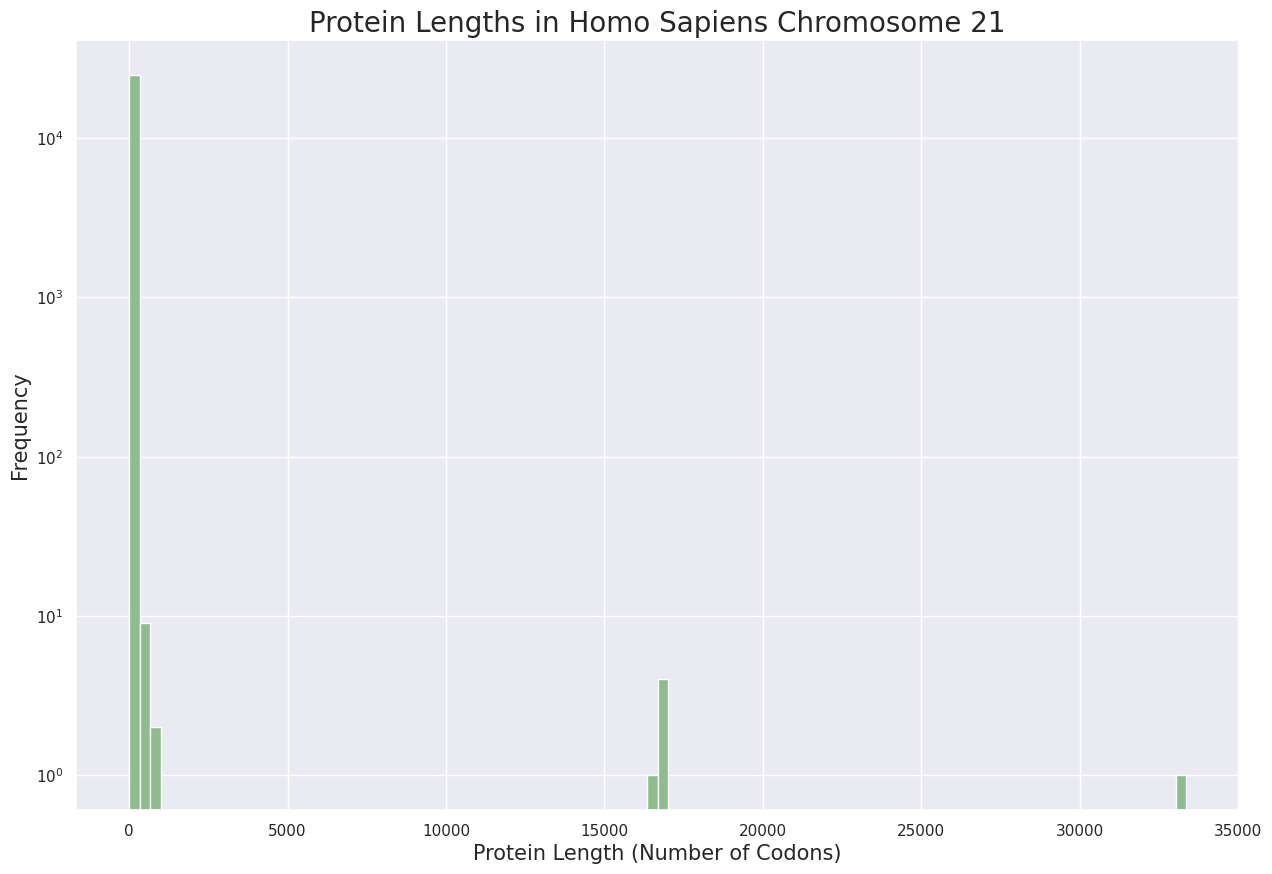

In [ ]:
# Now that we have our dataframe, let's create a histogram to visualize the
  # distribution of protein lengths we found on chromosome 21
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Create histogram
plt.figure(figsize=(15, 10)) # Adjust scatterplot size
ch21code_df['protein length'].plot(kind='hist', bins=100, logy=True,
                                   color= 'darkseagreen') # Input data
plt.title("Protein Lengths in Homo Sapiens Chromosome 21", fontsize = 20) # Title
plt.xlabel("Protein Length (Number of Codons)", fontsize = 15) # x-axis
plt.ylabel("Frequency", fontsize = 15) # y-axis
sns.set_style('darkgrid')
plt.show()

To better visualize the data (and especially see the distribution of the smaller proteins better), we can split up the data into small, medium, and large protein sizes in order to get a clearer picture.

In [ ]:
# We can split up the data based on protein sizes: small proteins with fewer
  #than 10,000 codons, medium-sized proteins between 10,000 and 25,000 codons
  # long, and large proteins with more than 25,000 codons

# Small Proteins
small_proteins_df = ch21code_df.loc[ch21code_df['protein length'] < 10000]
print("Number of Small Proteins: " + str(len(small_proteins_df)))
small_proteins_df

Number of Small Proteins: 24766


,amino acid sequence,protein length,nucleotides
0,MTEE,4,12
1,MKPVLLTASPWSLFVTEGHVFRQDCWVAVFCLLPARPWNSLWGPTL...,69,207
2,MTVTSLGSLHVGPPRTGSLRAMM,23,69
3,MAWEIQSS,8,24
4,MYLFIFILFIYLFVFETEACSVAQAGVQWRDLGSPQAPPPAFLPFS...,89,267
...,...,...,...
24767,MQQFGNTLFVETVSGYLDSCNDFVGNGN I I I I,36,108
24768,MCVPSQRII,9,27
24769,MPTVEKK,7,21
24770,MCVLNN,6,18


In [ ]:
# Medium Proteins
medium_proteins_df = ch21code_df.loc[ch21code_df['protein length'] >= 10000]
medium_proteins_df = medium_proteins_df.loc[medium_proteins_df['protein length'] <= 25000]
print("Number of Medium Proteins: " + str(len(medium_proteins_df)))
medium_proteins_df

Number of Medium Proteins: 5


,amino acid sequence,protein length,nucleotides
4547,M IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,16721,50163
5724,MYVYDLCRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,16680,50040
6482,MVS IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,16687,50061
8289,MQK IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,16743,50229
11358,MPRTVNVLYTIKSRVLSILGXXXXXXXXXXXXXXXXXXXXXXXXXX...,16692,50076


In [ ]:
large_protein = ch21code_df.loc[ch21code_df['protein length'] > 25000]
large_protein

,amino acid sequence,protein length,nucleotides
16362,MAYNQVKYLNTPLFK IXXXXXXXXXXXXXXXXXXXXXXXXXXXXX...,33362,100086


In [ ]:
# Examine sequences of medium-sized proteins for abundance of 'X (unidentified sequence)
for protein in medium_proteins_df['amino acid sequence']:
  print(protein[:100] + "\n")

M IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

MYVYDLCRXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

MVS IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

MQK IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

MPRTVNVLYTIKSRVLSILGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX



In [ ]:
# Examine large protein for abundance of 'X' (unidentified sequence)
large_protein.at[16362, 'amino acid sequence'][:1000]

'MAYNQVKYLNTPLFK IXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

We can see that the protein sequences for medium-size and large proteins for the most part consist of 'X', so we'll ignore these protein sequences, and create another histogram to better visualize the smaller proteins.

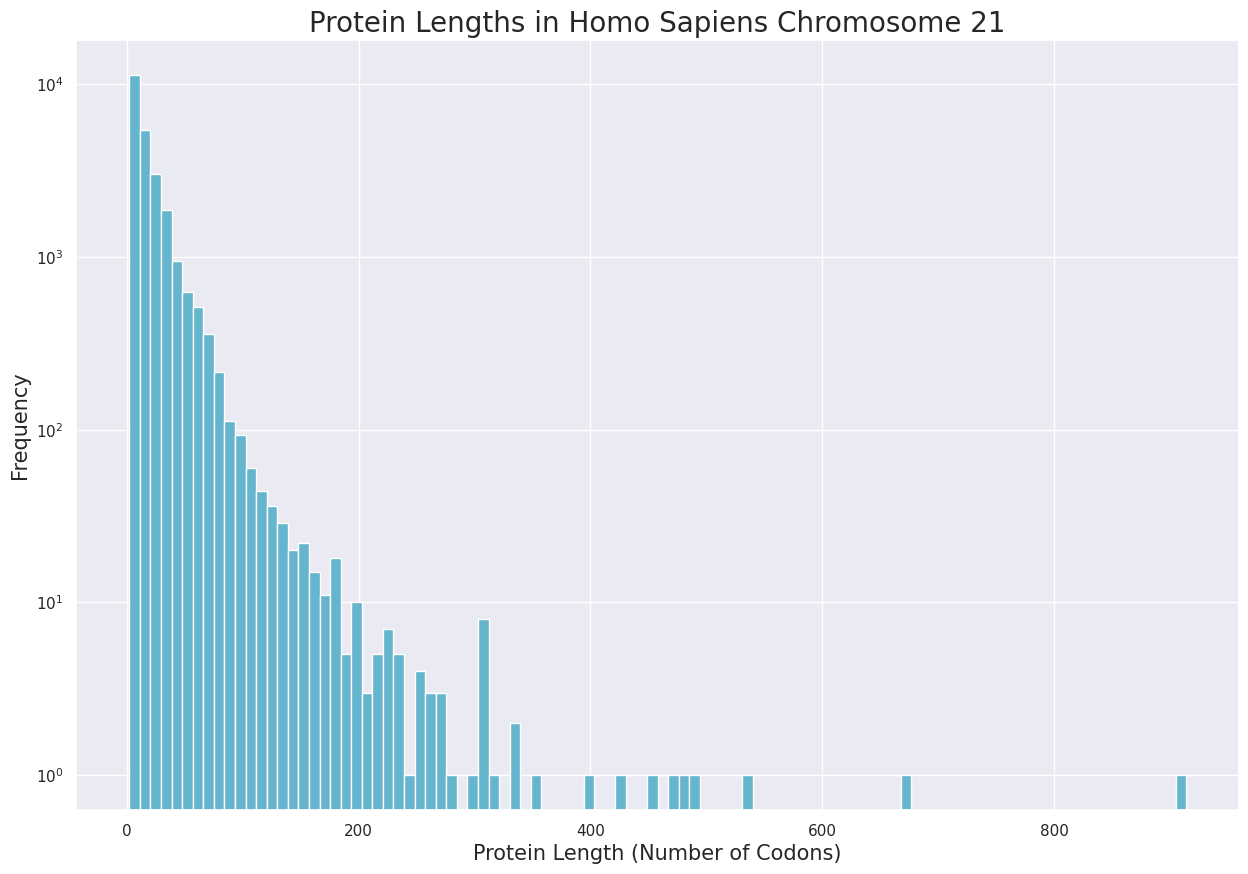

In [ ]:
# Histogram, excluding the large proteins with unidentified sequence data

# Create histogram
plt.figure(figsize=(15, 10)) # Adjust scatterplot size
small_proteins_df['protein length'].plot(kind='hist', bins=100, logy=True,
                                   color= 'c') # Input data
plt.title("Protein Lengths in Homo Sapiens Chromosome 21", fontsize = 20) # Title
plt.xlabel("Protein Length (Number of Codons)", fontsize = 15) # x-axis
plt.ylabel("Frequency", fontsize = 15) # y-axis
sns.set_style('darkgrid')
plt.show()